In [1]:
from pprint import pprint
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse import linalg
import math
from matplotlib import pyplot as plt

In [2]:
def Vorticity(u, v, dx, dy):
    """Calculates the Vorticity
    
    Params:
    -------
    x, y    2D arrays of float, x and y direction points
    u, v    2D arrays of float, u and v velocity vectors
    
    Returns:
    -------
    Vorticity  2D array of float, curl of the velocity field
    """

    dV = np.empty_like(v, dtype=float)
    dU = np.empty_like(u, dtype=float)
    
    dV = np.gradient(v)
    dU = np.gradient(u)
    
    V_gradient = dV[1]/dx
    U_gradient = dU[0]/dy
    
    Vorticity = V_gradient - U_gradient
    Vorticity[-1,:] = Vorticity[0,:]
    Vorticity[:,-1] = Vorticity[:,0]
    Vorticity[-2,:] = Vorticity[-1,:]
    Vorticity[:,-2] = Vorticity[:,-1]
    
    return Vorticity

In [3]:
def Build_G1(u, v, dx, dy, nu):
    """
    Calculates the G1 term for time marching NS Solver
    
    Params:
    -------
    u, v     2D array of float, u and v velocities
    dx, dy   float, step size in x and y
    nu       float, viscosity of the fluid
    
    Returns:
    -------
    Gu       2D array of float, G in x direction
    
    """
    
    Gu = np.zeros_like(u, dtype=float)  
        
    Gu[1:-1, 1:-1] = \
    (u[1:-1,2:] - 2 * u[1:-1, 1:-1] + u[1:-1,:-2]) / dx**2 \
  + (u[2:,1:-1] - 2 * u[1:-1, 1:-1] + u[:-2,1:-1]) / dy**2 \
  - 0.25 * ((u[1:-1,2:] + u[1:-1, 1:-1])**2 -
            (u[1:-1, 1:-1] + u[1:-1,:-2])**2) / dx \
  - 0.25 * ((u[2:,1:-1] + u[1:-1, 1:-1])*(v[2:-1,:-1]+v[2:-1,1:]) -
            (u[:-2,1:-1] + u[1:-1, 1:-1])*(v[1:-2,:-1]+v[1:-2,1:])) / dy
      
    return Gu

In [4]:
def Build_G2(u, v, dx, dy, nu):
    """
    Calculates the G2 term for time marching NS Solver
    
    Params:
    -------
    u, v     2D array of float, u and v velocities
    dx, dy   float, step size in x and y
    nu       float, viscosity of the fluid
    
    Returns:
    -------
    Gv       2D array of float, G in y direction
    
    """
    Gv = np.zeros_like(v, dtype=float)

    Gv[1:-1, 1:-1] = \
        (v[1:-1,2:] - 2 * v[1:-1, 1:-1] + v[1:-1,:-2]) / dx**2 \
      + (v[2:,1:-1] - 2 * v[1:-1, 1:-1] + v[:-2,1:-1]) / dy**2 \
      - 0.25 * ((u[1:,2:-1] + u[:-1,2:-1])*(v[1:-1,2:]+v[1:-1,1:-1]) -
            (u[1:,1:-2] + u[:-1,1:-2])*(v[1:-1, 1:-1]+v[1:-1,:-2])) / dx \
      - 0.25 * ((v[2:,1:-1] + v[1:-1, 1:-1])*(v[2:,1:-1] + v[1:-1, 1:-1]) -
            (v[:-2,1:-1]+ v[1:-1, 1:-1])*(v[:-2,1:-1]+v[1:-1, 1:-1])) / dy
    
    return Gv

In [5]:
def Pressure_Terms(P, dx, dy):
    """Computes the Pressure terms
    
    Params:
    -------
    P                       float, Pressure Points
    dx, dy                  float, x and y step size
    
    Returns:
    --------
    F1_P                    float, u direction Pressure terms
    F2_P                    float, v direction Pressure terms
    """
    
    F1_P = (P[:,1:] - P[:,:-1])/dx
    F2_P = (P[1:,:] - P[:-1,:])/dy
    
    return F1_P, F2_P

In [6]:
def Build_Sparse_A_Neumann(Nx, Ny):
    """Builds the A matrix for a 5 point stencil Poisson Solver
    
    Params:
    -------
    Nx, Ny     float, number of points in x and y
    
    Returns:
    -------
    A          Penta-diagonal sparse matrix A
    """
    
    A = sparse.diags([-4]*Nx*Ny, 0) #set leading Diaganol
    A = A + sparse.diags([1]*(Nx-1)+([0]+[1]*(Nx-1))*(Ny-1), 1) #set first diagonal above main
    A = A + sparse.diags([1]*(Nx-1)+([0]+[1]*(Nx-1))*(Ny-1), -1) #set first diagonal below main
    A = A + sparse.diags([1]*(Nx*Ny-Nx), Nx) #sets second diagonal above main
    A = A + sparse.diags([1]*(Nx*Ny-Nx), -Nx) #sets second diagonal below main
    
    return A

In [7]:
def Poisson_Solver_Neumann(Nx, Ny):
    """Solves the 2D Poisson equation implicitly on a staggered grid
    using Neumann Boundary Conditions
    
    Params:
    ------
    u, v           2D array of float, x and y velocities
    Nx, Ny         float, Number of segments in x and y
    dt             float, time step size
    T              float, current time
    X, Y           2D array of float, meshgrid
    
    Returns:
    -------
    ANeum        2D array of float, A matrix with Neumann conditions
    f_RHSn       1D array of float, f(x,y) for Neumann conditions
    """
    #Building A
    ANeum = np.zeros((Nx*Ny,Nx*Ny),dtype=float)

    a = 1.0
    b = 1.0
    c_int = -4.0 
    c_edge = -3.0
    c_corner = -2.0
    d = 1.0
    e = 1.0

    #Set corner points
    ANeum[0,0] = c_edge
    ANeum[-1,-1] = c_corner
    ANeum[Nx*Ny-Ny,Nx*Ny-Ny] = c_corner
    ANeum[Ny-1,Ny-1] = c_corner

    #Set edges in first block
    for j in range(1,Ny-1):
        ANeum[j,j] = c_edge
        j +=j

    #Set edges in last block
    for j in range((Nx*Ny)-Ny,(Nx*Ny)-2):
        ANeum[j+1,j+1] = c_edge
        j +=j

    #Set edges along main diagonal except for first block
    for j in range(Nx+1,Ny*Nx):
        if j % Nx ==0:
            ANeum[j-1,j-1] = c_edge
        j +=j

    #Set edges on main diagonal except for last block
    for j in range(Nx,(Ny*Nx)-Nx):
        if j % Nx ==0:
            ANeum[j,j] = c_edge
        j +=j

    #Second diagonal above and below diagonal
    for j in range(Ny,Ny*Nx):
        ANeum[j,j-Ny] = a
        ANeum[j-Nx,j] = e
        j +=j

    #first diagonal below main diagonal   
    for j in range(1,Ny*Nx):
        if j % Ny ==0:
            ANeum[j,j-1] = 0
        else:
            ANeum[j,j-1] = b
        j +=j

    #first diagonal above main diagonal
    for j in range(0,Ny*Nx):
        if j % Nx ==0:
            ANeum[j-1,j] = 0
        else:
            ANeum[j-1,j] = d
        j +=j

    #Main Diagonal
    for j in range(0,Ny*Nx):
        if ANeum[j,j] ==0:
            ANeum[j,j] = c_int
    
    return ANeum

In [8]:
def BCs(u, v, u_req):
    """Applies Dirichlet & Neumann Boundary conditions on u and v from
    
    Params:
    ------
    u, v            2D arrays of float, calculated u and v
    
    Returns:
    -------
    u, v            2D array of float, u and v with BCs applied
    """
    u[:,1] = 0 #left wall
    u[:,-2] = 0 #right wall
    u[0,:] = - u[1,:] #bottom wall
    u[-1,:] = u_req - u[-2,:] #top wall

    v[:,0] = - v[:,1] #left wall
    v[:,-1] = - v[:,-2] #right wall
    v[0,:] = 0 #bottom wall
    v[-1,:] = 0 #top wall

    return u, v

In [9]:
def RK3(u, v, Nx, Ny, dx, dy, nu, nt, u_req):
    for t in range(0,nt):
        un = np.empty_like(u)
        vn = np.empty_like(v)
        #copy info from last loop, needed for current loop into variable_n
        un = u.copy()
        vn = v.copy()
        #Pn = p.copy()
        T = 0 + t*dt

        ####STEP 1
        ### t -----> t + (1/3)*dt
        un, vn = BCs(un, vn, u_req)
        G1 = Build_G1(un, vn, dx, dy, nu)
        G2 = Build_G2(un, vn, dx, dy, nu)
        u1 = un + (1.0/3.0*dt*G1)
        v1 = vn + (1.0/3.0*dt*G2)
        u1, v1 = BCs(u1, v1, u_req)
        #Solve for Pressure Field
        b1 = np.zeros((Ny+2,Nx+2), dtype=float)
        b1[1:-1,1:-1] = ((u1[1:-1,2:-1] - u1[1:-1,1:-2])/dx +\
            (v1[2:-1,1:-1] - v1[1:-2,1:-1])/dy)*(dx**2)
        b1 = np.reshape(b1[1:-1,1:-1], Ny*Nx)
        A1 = Build_Sparse_A_Neumann(Nx, Ny)
        b1 = b1[:]*(3.0/dt)
        temp1 = scipy.sparse.linalg.spsolve(A1,b1)

        p_star = np.reshape(temp1, (Ny,Nx))
        p_star = p_star[:,:] - p_star[Ny/2,Nx/2]

        F1_Pstar, F2_Pstar = Pressure_Terms(p_star, dx, dy)

        #calc predictor velocities
        u_star = u1.copy()
        v_star = v1.copy()

        u_star[1:-1,2:-2] = u1[1:-1,2:-2] - (1.0/3.0*dt*F1_Pstar)
        v_star[2:-2,1:-1] = v1[2:-2,1:-1] - (1.0/3.0*dt*F2_Pstar)

        ####STEP 2
        ### t + (1/3)*dt -----> t + (3/4)*dt
        u_star, v_star = BCs(u_star, v_star, u_req)
        G1_star = ((-5.0/9.0)*G1) + Build_G1(u_star, v_star, dx, dy, nu)
        G2_star = ((-5.0/9.0)*G2) + Build_G2(u_star, v_star, dx, dy, nu)
        u2 = u_star + ((15.0/16.0)*dt*G1_star)
        v2 = v_star + ((15.0/16.0)*dt*G2_star)
        u2, v2 = BCs(u2, v2, u_req)
        #Solve for Pressure Field
        b2 = np.zeros((Ny+2,Nx+2), dtype=float)
        b2[1:-1,1:-1] = ((u2[1:-1,2:-1] - u2[1:-1,1:-2])/dx +\
            (v2[2:-1,1:-1] - v2[1:-2,1:-1])/dy)*(dx**2)
        b2 = np.reshape(b2[1:-1,1:-1], Ny*Nx)
        A2 = Build_Sparse_A_Neumann(Nx, Ny)
        b2 = b2[:]*(12.0/(5.0*dt))
        temp2 = scipy.sparse.linalg.spsolve(A2,b2)
        p_dstar = np.reshape(temp2, (Ny,Nx))
        p_dstar = p_dstar[:,:] - p_dstar[Ny/2,Nx/2]

        F1_Pdstar, F2_Pdstar = Pressure_Terms(p_dstar, dx, dy)

        #calc predictor velocities
        u_dstar = u2.copy()
        v_dstar = v2.copy()

        u_dstar[1:-1,2:-2] = u2[1:-1,2:-2] - ((5.0/12.0)*dt*F1_Pdstar)
        v_dstar[2:-2,1:-1] = v2[2:-2,1:-1] - ((5.0/12.0)*dt*F2_Pdstar)

        ####STEP 3
        ### t + (3/4)*dt ------> t + dt
        u_dstar, v_dstar = BCs(u_dstar, v_dstar, u_req)
        G1_dstar = ((-153.0/128.0)*G1_star) + Build_G1(u_dstar, v_dstar, dx, dy, nu)
        G2_dstar = ((-153.0/128.0)*G2_star) + Build_G2(u_dstar, v_dstar, dx, dy, nu)
        u3 = u_dstar + ((8.0/15.0)*dt*G1_dstar)
        v3 = v_dstar + ((8.0/15.0)*dt*G2_dstar)
        u3, v3 = BCs(u3, v3, u_req)
        #Solve for the Pressure Field
        b3 = np.zeros((Ny+2,Nx+2), dtype=float)
        b3[1:-1,1:-1] = ((u3[1:-1,2:-1] - u3[1:-1,1:-2])/dx +\
            (v3[2:-1,1:-1] - v3[1:-2,1:-1])/dy)*(dx**2)
        b3 = np.reshape(b3[1:-1,1:-1], Ny*Nx)
        A3 = Build_Sparse_A_Neumann(Nx, Ny)
        b3 = b3[:]*(4.0/dt)
        temp3 = scipy.sparse.linalg.spsolve(A3,b3)
        p = np.reshape(temp3, (Ny,Nx))
        p = p[:,:] - p[Ny/2,Nx/2]

        #Calculate the Pressure Terms
        F1_P, F2_P = Pressure_Terms(p, dx, dy)

        #calc predictor velocities
        u = u3.copy()
        v = v3.copy()

        u[1:-1,2:-2] = u3[1:-1,2:-2] - ((1.0/4.0)*dt*F1_P)
        v[2:-2,1:-1] = v3[2:-2,1:-1] - ((1.0/4.0)*dt*F2_P)
        #u, v = BCs(u, v)

        if t % 100 == 0:
            print 'time step is %1.0f' % t
            
    return u, v, p

In [10]:
def error_analysis(num_sol,exact_sol):
    """Computes L2 norm of calculated solution
    
    Params:
    ------
    N_cx, N_cy  Number of cell centered points
    x_vals      calculated x_values
    exact_sol   Analytical Solution
    
    Returns:
    -------
    num         Number of total points
    normdiff    L2 norm of calculated solution
    """
    diff = num_sol - exact_sol
    norm2diff = np.linalg.norm(diff,ord=2)/np.sqrt(np.sum((exact_sol**2)))
    normdiff = np.linalg.norm(diff,ord=1)/np.sqrt(np.sum((exact_sol**2)))
    
    return normdiff, norm2diff

In [11]:
def Pressure_Plotting(p, xp, yp, Nx, nt):
    p_min = np.min(p)
    p_max = np.max(p)

    %matplotlib inline
    size=8
    plt.figure(figsize=(size,size))
    plt.xlim(0,2.0)
    plt.ylim(0,2.0)
    plt.xlabel('x')
    plt.ylabel('y')
    contf = plt.contour(xp, yp, p, levels = np.linspace(p_min\
        ,p_max,25))
    cbar = plt.colorbar(contf)
    cbar.set_label('Pressure', fontsize=16)
    cbar.set_ticks(np.linspace(p_min,p_max,7))
    loc = './Plots/Lid_Driven_Cavity/Pressure_Plot_%1.0f.png' % Nx
    plt.savefig(loc);
    
def u_Plotting(u, xu, yu, Nx, nt):
    u_min = np.min(u)
    u_max = np.max(u)

    %matplotlib inline
    size=8
    plt.figure(figsize=(size,size))
    plt.xlim(0,2.0)
    plt.ylim(0,2.0)
    plt.xlabel('x')
    plt.ylabel('y')
    contf = plt.contour(xu, yu, u, levels = np.linspace(u_min\
        ,u_max,25))
    cbar = plt.colorbar(contf)
    cbar.set_label('u-Velocity', fontsize=16)
    cbar.set_ticks(np.linspace(u_min,u_max,7))
    loc = './Plots/Lid_Driven_Cavity/u_Plot_%1.0f.png' % Nx
    plt.savefig(loc);
    
def v_Plotting(v, xv, yv, Nx, nt):
    v_min = np.min(v)
    v_max = np.max(v)

    %matplotlib inline
    size=8
    plt.figure(figsize=(size,size))
    plt.xlim(0,2.0)
    plt.ylim(0,2.0)
    plt.xlabel('x')
    plt.ylabel('y')
    contf = plt.contour(xv, yv, v, levels = np.linspace(v_min\
        ,v_max,25))
    cbar = plt.colorbar(contf)
    cbar.set_label('v-Velocity', fontsize=16)
    cbar.set_ticks(np.linspace(v_min,v_max,7))
    loc = './Plots/Lid_Driven_Cavity/v_Plot_%1.0f.png' % Nx
    plt.savefig(loc);
    
def Vorticity_Plotting(u, v, vorticity, xv, yv, Nx, nt):
    vort_min = np.min(vorticity)
    vort_max = np.max(vorticity)

    %matplotlib inline
    size=8
    plt.figure(figsize=(size,size))
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.xlim(0.0,2.0)
    plt.ylim(0.0,2.0)
    plt.title('Lid Driven Cavity \n Vorticity and Velocity Vectors', fontsize=20)
    plt.quiver(xv, yv[1:] ,u[:,1:], v[1:,:], units='width', zorder=2)
    contf = plt.contour(xv, yv[1:], vorticity, levels = np.linspace(vort_min\
        ,vort_max,25))
    cbar = plt.colorbar(contf)
    cbar.set_label('Vorticity', fontsize=16)
    cbar.set_ticks(np.linspace(vort_min,vort_max,7))
    loc = './Plots/Lid_Driven_Cavity/Vorticity_Plot_%1.0f.png' % Nx
    plt.savefig(loc);
    
def Streamlines_Plotting(u, v, xu, yu, Nx, nt):

    %matplotlib inline
    size=8
    plt.figure(figsize=(size,size))
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.xlim(0.0,2.0)
    plt.ylim(0.0,2.0)
    plt.title('Lid Driven Cavity \n Streamlines', fontsize=20)
    plt.streamplot(xu[1:], yu, u[:,1:], v[1:,:], density=2, linewidth=1, arrowsize=1, arrowstyle='->')
    loc = './Plots/Lid_Driven_Cavity/Streamlines_Plot_%1.0f.png' % Nx
    plt.savefig(loc);
    
def CP_Plotting(u, v, xu, yu, Nx, nt):
    V = np.sqrt(u[:,1:]**2 + v[1:,:]**2)
    V_infinity = np.ones((Ny+2,Nx+2), dtype=float)
    C_P = 1 - ((V/V_infinity)**2)
    min_cp = np.min(C_P)
    max_cp = np.max(C_P)

    %matplotlib inline
    size = 8
    fig = plt.figure(figsize=(size,size))
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.xlim(0.0,2.0)
    plt.ylim(0.0,2.0)
    plt.title('Coefficient of Pressure', fontsize=20)
    contf = plt.contour(xu[1:],yu,C_P, levels=np.linspace(min_cp, max_cp, 25))
    cbar = plt.colorbar(contf)             
    cbar.set_label('$C_P$', fontsize=16)
    cbar.set_ticks(np.linspace(min_cp,max_cp,7))
    loc = './Plots/Lid_Driven_Cavity/CP_Plot_%1.0f.png' % Nx
    plt.savefig(loc);

In [12]:
def Generate_Grid(Lx, Ly, Nx, Ny, x_s, y_s):
    """Generates a 2D staggered Grid
    
    Params:
    -------
    Lx, Ly     float, length of grid in x and y
    Nx, Ny     float, number of points in x and y not includeing ghost cells
    xs, ys     float, starting points in x and y
    
    Returns:
    -------
    dx, dy     float, step size in x and y
    x, y       1D array of float, x and y points
    xp, yp     1D array of float, pressure point grid in x and y
    p_exact    2D array of float, array for exact pressure
    xu, yu     1D array of float, u velocity grid in x and y
    u_exact    2D array of float, array for exact u
    ut         2D array of float, array for time varying u
    xv, yv     1D array of float, v velocity grid in x and y
    v_exact    2D array of float, array for exact v
    vt         2D array of float, array for time varying v
    """
    
    dx = Lx/(Nx)
    dy = Ly/(Ny)
    
    x = np.zeros((Nx+2,1), dtype=float)
    y = np.zeros((Ny+2,1), dtype=float)
        
    # Pressure Points
    xp = np.zeros(Nx, dtype=float)
    yp = np.zeros(Ny, dtype=float)
    p_exact = np.zeros((Ny,Nx), dtype=float)


    # u velocity points
    xu = np.zeros(Nx+3, dtype=float)
    yu = np.zeros(Ny+2, dtype=float)
    u_exact = np.zeros((Ny+2,Nx+3), dtype=float)
    #ut = np.zeros_like((Ny+2,Nx+3,nt), dtype=float)

    # v velocity points
    xv = np.zeros(Nx+2, dtype=float)
    yv = np.zeros(Ny+3, dtype=float)
    v_exact = np.zeros((Ny+3,Nx+2), dtype=float)
    #vt = np.zeros_like((Ny+3,Nx+2,nt), dtype=float)
    
    #Pressure
    #for i in range(0,Nx+2):
    xp = np.linspace(dx/2.0,Lx-dx/2.0,Nx)
    yp = np.linspace(dy/2.0,Ly-dy/2.0,Ny)

    #u Velocity
    xu = np.linspace(-dx,Lx+dx,Nx+3)
    yu = np.linspace(-dy/2.0,Ly+dy/2.0,Ny+2)

    #v Velocity
    xv = np.linspace(-dx/2.0,Lx+dx/2.0,Nx+2)
    yv = np.linspace(-dy,Ly+dy,Ny+3)
    
    return x, y, xp, yp, p_exact, xu, yu, u_exact, xv, yv, v_exact, dx, dy

In [25]:
#Initial Conditions and Parameters
nu = 1#.846e-5  #viscosity of air
rho = 1#.165 #density of air
Re100 = 100 #desired Reynolds Number
Re400 = 400
t_s, t_e = 0, 2.0   #start and end times
dt = .0001
nt = int((t_e-t_s)/dt)

Lx = 2.0
Ly = 2.0
Nx = 64
Ny = 64
xs, ys = 0.0, 0.0
u_req100 = (Re100*nu)/(rho*Lx)
u_req400 = (Re400*nu)/(rho*Lx)
#Call mesh
x, y, xp, yp, p_exact, xu, yu, u_exact, xv, yv, v_exact,\
    dx, dy = Generate_Grid(Lx, Ly, Nx, Ny, xs, ys)

In [ ]:
#Call my IC's
uIC = np.zeros((Ny+2,Nx+3), dtype=float)
vIC = np.zeros((Ny+3,Nx+2), dtype=float)
pIC = np.zeros((Ny+2,Nx+2), dtype=float)
uIC, vIC = BCs(uIC, vIC, u_req100)
#Call RK3
u, v, p = RK3(uIC, vIC, Nx, Ny, dx, dy, nu, nt, u_req100)
#Calc Vorticity
vort = Vorticity(u[:,1:], v[1:,:], dx, dy)

time step is 0
time step is 100
time step is 200
time step is 300
time step is 400
time step is 500
time step is 600
time step is 700
time step is 800
time step is 900
time step is 1000
time step is 1100
time step is 1200
time step is 1300
time step is 1400
time step is 1500
time step is 1600
time step is 1700
time step is 1800
time step is 1900
time step is 2000
time step is 2100
time step is 2200
time step is 2300
time step is 2400
time step is 2500
time step is 2600
time step is 2700
time step is 2800
time step is 2900
time step is 3000
time step is 3100
time step is 3200
time step is 3300
time step is 3400
time step is 3500
time step is 3600
time step is 3700
time step is 3800
time step is 3900
time step is 4000
time step is 4100
time step is 4200
time step is 4300

In [24]:
np.savez('Lid_Data/u_v_p_64x64_Re100', u_num=u, v_num=v, p_num=p, vort_num=vort)

In [68]:
temp100 = np.load('Lid_Data/u_v_p_32x32_Re100.npz')
temp400 = np.load('Lid_Data/u_v_p_32x32_Re400.npz')

temp100_64 = np.load('Lid_Data/u_v_p_64x64_Re100.npz')
temp400_64 = np.load('Lid_Data/u_v_p_64x64_Re400.npz')

temp100_u = temp100['u_num']
temp100_v = temp100['v_num']
temp100_p = temp100['p_num']
temp100_vort = temp100['vort_num']

temp100_u_64 = temp100_64['u_num']
temp100_v_64 = temp100_64['v_num']
temp100_p_64 = temp100_64['p_num']
temp100_vort_64 = temp100_64['vort_num']

temp400_u = temp400['u_num']
temp400_v = temp400['v_num']
temp400_p = temp400['p_num']
temp400_vort = temp400['vort_num']

temp400_u_64 = temp400_64['u_num']
temp400_v_64 = temp400_64['v_num']
temp400_p_64 = temp400_64['p_num']
temp400_vort_64 = temp400_64['vort_num']

In [69]:
x_me = np.linspace(0.0,1.0, Nx+2)
y_me = np.linspace(0.0,1.0, Ny+3)
Re100ggs_u = [0.0, -0.03717, -0.04192, -0.04775, -0.06434, -0.10150, -0.15662, -0.21090, -0.20581, -0.13641, 0.00332,\
    0.23151, 0.68717, 0.73722, 0.78871, 0.84123, 1.0]
Re400ggs_u = [0.0, -0.08186, -0.09266, -0.10338, -0.14612, -0.24299, -0.32726, -0.17119, -0.11477, 0.02135, 0.16256,\
    0.29093, 0.55892, 0.61756, 0.68439, 0.75837, 1.0]
Re100ggs_v = [0.0, 0.09233, 0.10091, 0.10890, 0.12317, 0.16077, 0.17507, 0.17527, 0.05454, -0.24533, -0.22445,\
    -0.16914, -0.10313, -0.0864, -0.07391, -0.05906, 0.0]
Re400ggs_v = [0.0, 0.18360, 0.19713, 0.20920, 0.22965, 0.28124, 0.30203, 0.30174, 0.05186, -0.38598, -0.44993,\
    -0.23827, -0.22847, -0.19254, -0.15663, -0.12146, 0.0]
x_ggs = [0.0, 0.0625, 0.0703, 0.0781, 0.0938, 0.1563, 0.2266, 0.2344, 0.5, 0.8047, 0.8594, 0.9063, 0.9453, 0.9531,\
    0.9609, 0.9688, 1.0]
y_ggs = [0.0, 0.0547, 0.0625, 0.0703, 0.1016, 0.1719, 0.2813, 0.4531, 0.5, 0.6172, 0.7344, 0.8516, 0.9531, 0.9609,\
    0.9688, 0.9766, 1.0]

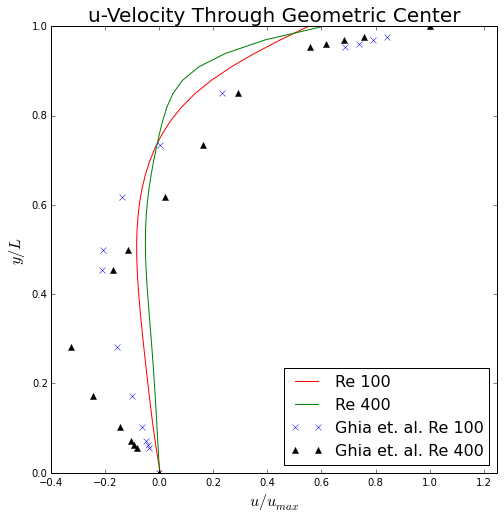

In [70]:
%matplotlib inline
size = 8
fig = plt.figure(figsize=(size,size))
plt.xlabel('$u/u_{max}$', fontsize=16)
plt.ylabel('$y/L$', fontsize=16)
plt.xlim(-0.4,1.25)
plt.ylim(0.0,1.0)
plt.title('u-Velocity Through Geometric Center', fontsize=20)
plt.plot((temp100_u[:,Nx/2]/np.max(temp100_u[:,Nx/2])), x_me, 'r-', label='Re 100, 32x32')
plt.plot((temp400_u[:,Nx/2]/np.max(temp400_u[:,Nx/2])), x_me, 'g-', label='Re 400, 32x32')
plt.plot((temp100_u_64[:,Nx/2]/np.max(temp100_u_64[:,Nx/2])), x_me, 'm-', label='Re 100, 64x64')
plt.plot((temp400_u_64[:,Nx/2]/np.max(temp400_u_64[:,Nx/2])), x_me, 'c-', label='Re 400, 64x64')
plt.plot(Re100ggs_u, y_ggs, 'bx', label='Ghia et. al. Re 100')
plt.plot(Re400ggs_u, y_ggs, 'k^', label='Ghia et. al. Re 400')
plt.legend(loc='best', prop={'size':16});
loc = './Plots/Lid_Driven_Cavity/u_GC_Plot.png'
plt.savefig(loc);

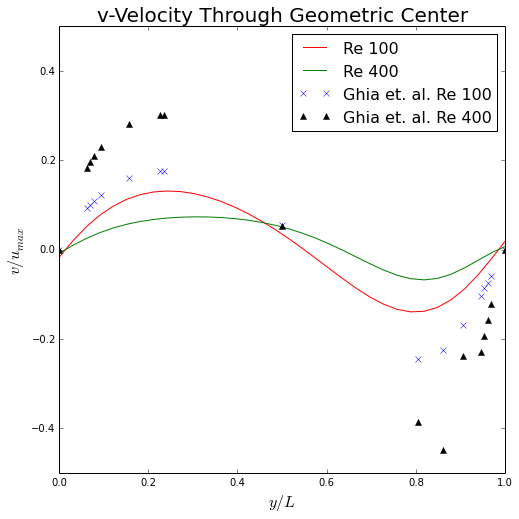

In [71]:
%matplotlib inline
size = 8
fig = plt.figure(figsize=(size,size))
plt.xlabel('$y/L$', fontsize=16)
plt.ylabel('$v/u_{max}$', fontsize=16)
plt.xlim(0.0,1.0)
plt.ylim(-0.5,0.5)
plt.title('v-Velocity Through Geometric Center', fontsize=20)
plt.plot(x_me,(temp100_v[Ny/2,:]/np.max(temp100_u[:,Nx/2])), 'r-', label='Re 100')
plt.plot(x_me,(temp400_v[Ny/2,:]/np.max(temp400_u[:,Nx/2])), 'g-', label='Re 400')
plt.plot(x_me,(temp100_v_64[Ny/2,:]/np.max(temp100_u_64[:,Nx/2])), 'm-', label='Re 100, 64x64')
plt.plot(x_me,(temp400_v_64[Ny/2,:]/np.max(temp400_u_64[:,Nx/2])), 'c-', label='Re 400, 64x64')
plt.plot(x_ggs, Re100ggs_v, 'bx', label='Ghia et. al. Re 100')
plt.plot(x_ggs, Re400ggs_v, 'k^', label='Ghia et. al. Re 400')
plt.legend(loc='best', prop={'size':16});
loc = './Plots/Lid_Driven_Cavity/v_GC_Plot.png'
plt.savefig(loc);

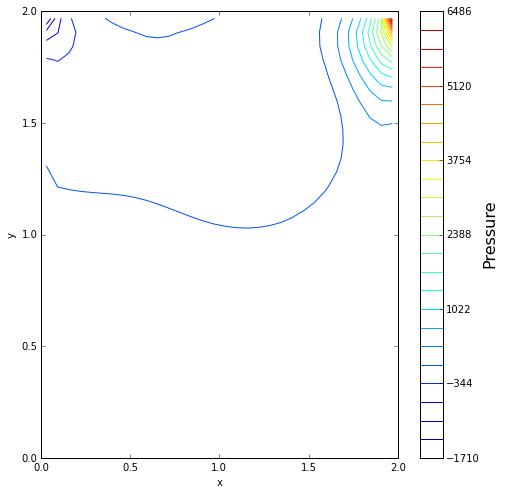

In [73]:
#plotting
Pressure_Plotting(temp400_p, xp, yp, Nx, nt)

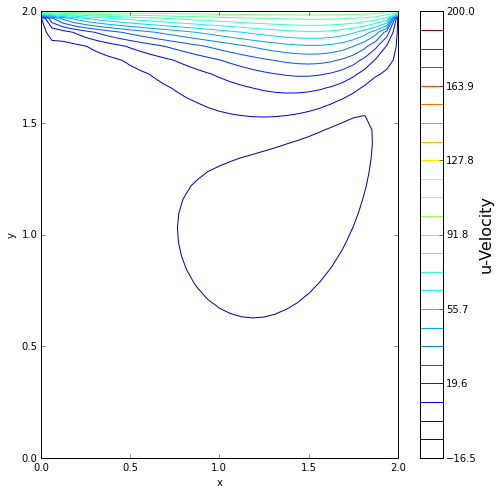

In [75]:
u_Plotting(temp400_u, xu, yu, Nx, nt)

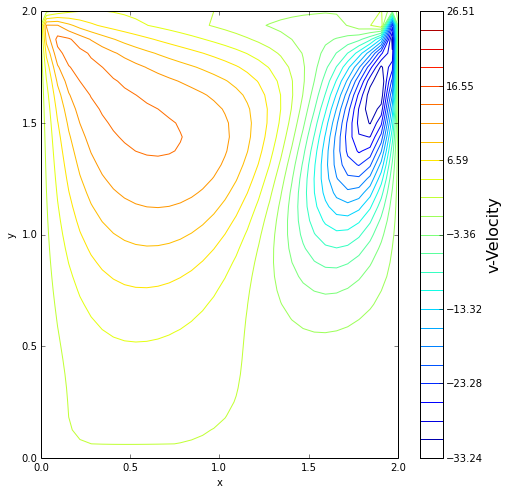

In [77]:
v_Plotting(temp400_v, xv, yv, Nx, nt)

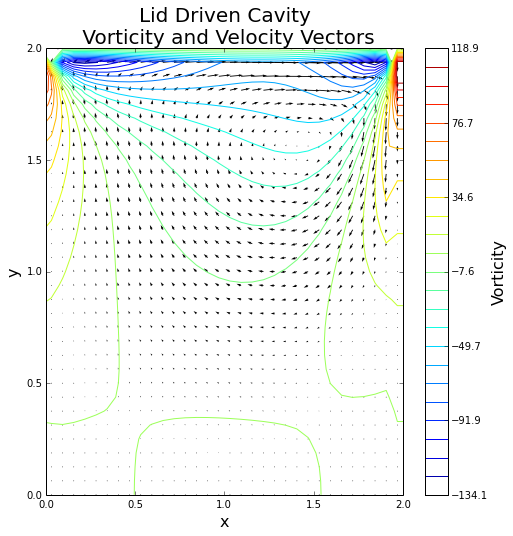

In [79]:
Vorticity_Plotting(temp400_u, temp400_v, temp100_vort, xv, yv, Nx, nt)

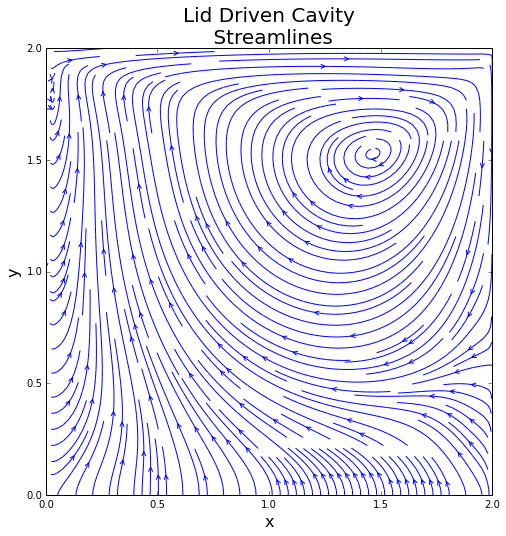

In [81]:
Streamlines_Plotting(temp400_u, temp400_v, xu, yu, Nx, nt)

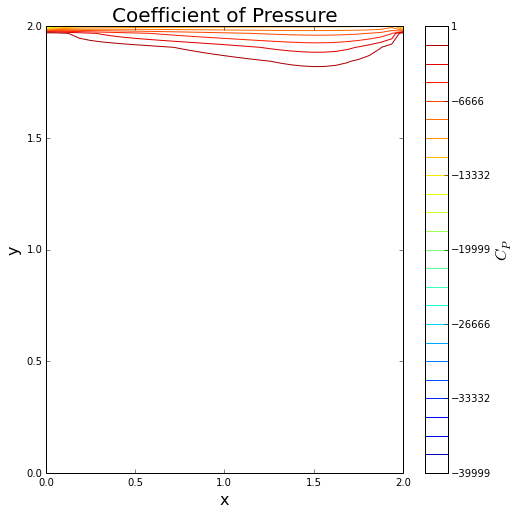

In [83]:
CP_Plotting(temp400_u, temp400_v, xu, yu, Nx, nt)